In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 2*x + 1

In [3]:
f(3.0)

22.0

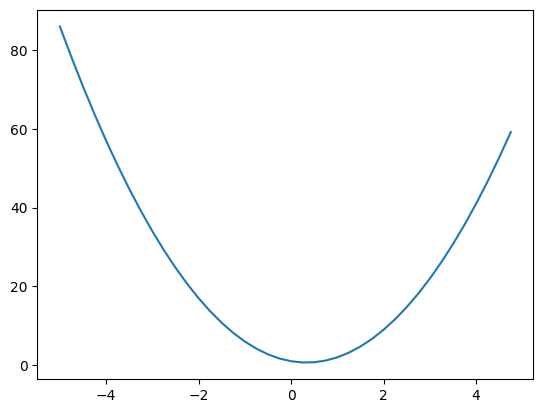

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.00001
x = -3.0
(f(x + h) - f(x)) / h

-19.999970000128542

In [6]:
a = 2. 
b = -3.
c = 10.
d = a*b + c
print(d)

4.0


In [7]:
d1 = a*b + c
a += h
d2 = a*b + c
print(d2)

3.9999699999999994


In [8]:
(d2 - d1) / h

-3.000000000064062

In [ ]:
a

a + b 
a * b

In [35]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    # def __sub__(self, other):
    #     out = Value(self.data.__add__(-1 * other.data), (self, other))
    #     return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

In [40]:
from graphviz import Digraph

def trace(root):
    # Builds a set of all nodes and edges in the graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    # Creates a graphviz visualization of the computational graph
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    
    # Add nodes to graph
    for n in nodes:
        uid = str(id(n))
        # Node label: data value | operation
        label = f"{n.label} | data: {n.data:.4f} | grad: {n.grad:.4f}"
        dot.node(name=uid, label=label, shape='record')
        
        if n._op:
            # Add operation label with circle shape
            dot.node(name=uid + n._op, label=n._op, shape='circle')
            dot.edge(uid + n._op, uid)
    
    # Add edges to graph
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [37]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10., label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
# print(d)
f = Value(-2., label='f')
L = d * f; L.label = 'L'

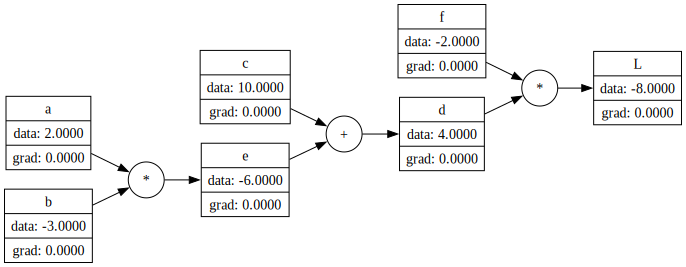

In [38]:
# Visualize the computational graph for d
draw_dot(L)